# Gesture Recognition
## Libraries required for building and training the models:

In [2]:
import numpy as np
import os
import scipy.misc
import imageio
import skimage
import datetime
import os
import cv2
import random as rn
from keras import backend as K
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,LSTM
from keras.layers.convolutional import Conv2D,Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers
from keras.applications import mobilenet
from keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
%matplotlib inline


## We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

## We use the below function, so that we use the system GPU (if available), for faster model training time:

In [4]:
tf.config.run_functions_eagerly(False)

## Generator
### The generator function below is used for processing, resizing and augmenting the image, before feeding the same to the model for training.

In [5]:
def generator_new(source_path, folder_list, batch_size=32,sample_size=30,image_height=100,image_width=100,augment=False):
    img_idx = np.round(np.linspace(0,29,sample_size)).astype(int)
    batch_size=batch_size
    while True:
        random_folder_list = np.random.permutation(folder_list)
        num_batches = len(random_folder_list)//batch_size

        for batch in range(num_batches): 
            batch_data, batch_labels= generate_batch_data(source_path,random_folder_list,batch,batch_size,img_idx,augment,0,image_height,image_width)
            yield batch_data, batch_labels 

        remaining_seq=len(random_folder_list)%batch_size

        if (remaining_seq != 0):
            batch_data, batch_labels= generate_batch_data(source_path,random_folder_list,num_batches,batch_size,img_idx,augment,remaining_seq,image_height,image_width)
            yield batch_data, batch_labels 


def generate_batch_data(source_path,random_folder_list,batch,batch_size,img_idx,augment,remaining_seq=0, image_height=100 , image_width=100):

    seq_len = remaining_seq if remaining_seq else batch_size

    batch_data = np.zeros((seq_len,len(img_idx),image_height,image_width,3)) 
    batch_labels = np.zeros((seq_len,5)) 




    for folder in range(seq_len): 
        imgs = os.listdir(source_path+'/'+ random_folder_list[folder + (batch*batch_size)].split(';')[0]) 
        for idx,item in enumerate(img_idx):
            #performing image reading and resizing
            image = imageio.imread(source_path+'/'+ random_folder_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image_resized=skimage.transform.resize(image,(image_height,image_width,3))
        
       
            if augment:

                #Converting the colour images to grayscale(black and white) for faster processing.
                gray = cv2.cvtColor(image_resized,cv2.COLOR_BGR2GRAY) #shifted,cv2.COLOR_BGR2GRAY)


        
                batch_data[folder,idx,:,:,0] = (gray[:,:])/255
                batch_data[folder,idx,:,:,1] = (gray[:,:])/255
                batch_data[folder,idx,:,:,2] = (gray[:,:])/255
            
            else:
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
        
        batch_labels[folder, int(random_folder_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        



    return(batch_data,batch_labels)

## Model

### Function for plotting the accuracy and loss values, after training the model:

In [6]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### Function to train the model:
#### The function peforms the following:
#### <li>Training and validation generator creation, by calling the above generator function.</li>
#### <li>Model checkpoint creation.</li>
#### <li>Validation steps and steps per epoch calculation.</li>
#### <li>Model training.</li>
#### NOTE: The method fit() used below achieves the same functionality as fit_generator().

In [7]:
def train_model(model,batch_size,sample_size,num_epochs,image_height,image_width):
    train_doc = np.random.permutation(open('notebooks/storage/Final_data/Collated_training/train.csv').readlines())
    val_doc = np.random.permutation(open('notebooks/storage/Final_data/Collated_training/val.csv').readlines())
    
    curr_dt_time = datetime.datetime.now()
    train_path = 'notebooks/storage/Final_data/Collated_training/train'
    val_path = 'notebooks/storage/Final_data/Collated_training/val'
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    
    print ('# epochs =', num_epochs)
    
    
    
    train_generator = generator_new(source_path=train_path, folder_list=train_doc, batch_size=batch_size, sample_size=sample_size, image_height=image_height, image_width=image_width,augment=True)

    val_generator = generator_new(source_path=val_path, folder_list=val_doc, batch_size=batch_size, sample_size=sample_size, image_height=image_height, image_width=image_width,augment=True)
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    

    callbacks_list = [checkpoint, LR]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history
    

## Best performing model:
### <b>Model 2:</b> 
### (please refer to the write-up document)
#### Transfer learning (mobilenet) with training of all weights, augmentation(gray scaling),bigger GRU cells, dropouts and MaxPooling2D.


In [7]:
baseModel = mobilenet.MobileNet(weights='imagenet', include_top=False)
model2=Sequential()
model2.add(TimeDistributed(baseModel,input_shape=(16,120,120,3)))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2,2))))
model2.add(TimeDistributed(Flatten()))
model2.add(GRU(128))
model2.add(Dropout(0.25))
model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(5,activation='softmax'))
optimiser=tf.keras.optimizers.Adam()
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

## Model training and plotting of the training and validation loss and accuracy values:
#### <b>Training accuracy (categorical):</b> 0.9849
#### <b>Validation accuracy (categorical):</b> 0.95

# training sequences = 663
# validation sequences = 100
# epochs = 30
Epoch 1/30


2022-03-24 22:08:03.785681: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


133/133 [==============================] - ETA: 0s - loss: 1.3813 - categorical_accuracy: 0.3982
Epoch 1: val_loss improved from inf to 1.14192, saving model to model_init_2022-03-2422_08_02.163567/model-00001-1.38134-0.39819-1.14192-0.55000.h5
133/133 [==============================] - 169s 1s/step - loss: 1.3813 - categorical_accuracy: 0.3982 - val_loss: 1.1419 - val_categorical_accuracy: 0.5500 - lr: 0.0010
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.9428 - categorical_accuracy: 0.6425
Epoch 2: val_loss improved from 1.14192 to 0.78568, saving model to model_init_2022-03-2422_08_02.163567/model-00002-0.94276-0.64253-0.78568-0.76000.h5
133/133 [==============================] - 779s 6s/step - loss: 0.9428 - categorical_accuracy: 0.6425 - val_loss: 0.7857 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.7617 - categorical_accuracy: 0.7285
Epoch 3: val_loss improved from 0.78568 to 0.6071

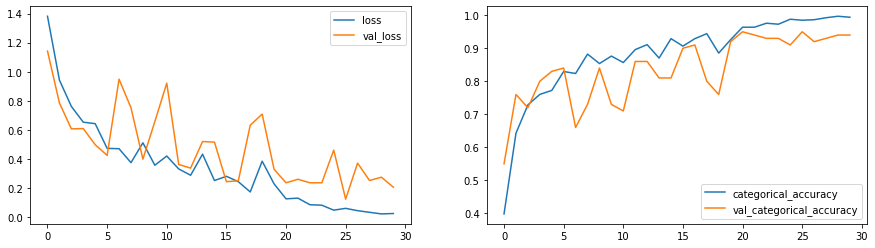

In [8]:
history2 = train_model(model2,batch_size=5,sample_size=16,num_epochs=30,image_height=120,image_width=120)
plot(history2)